# AlexNet

In [1]:
# torch
import torch 
import torch.nn as nn
import torch.optim as optim  
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision.datasets import ImageFolder
from torch.utils.data import (
    Dataset,
    DataLoader,
    Subset
) 

# other
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import warnings
from skimage import io
import time
import copy
import cv2
from tqdm import tqdm

warnings.filterwarnings("ignore")

# helper functions
from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix, compute_accuracy, cal_pre_rec
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import UnNormalize
from data_loading_functions import split_train_test_loaders, show_img, convert_lab
from helper_Gradcam import store_gradcam_image



# Settings

In [2]:
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0005
BATCH_SIZE = 64
NUM_EPOCHS = 40

# Architecture
NUM_FEATURES = 224*224
NUM_CLASSES = 4

# Other
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GRAYSCALE = False

# Load Data and Preprocessing 

In [3]:
dataset_path = '.\\COVID-19_Radiography_Dataset'
datas, train_loader, valid_loader, test_loader = split_train_test_loaders(dataset_path, batch_size= BATCH_SIZE)

# Display Images

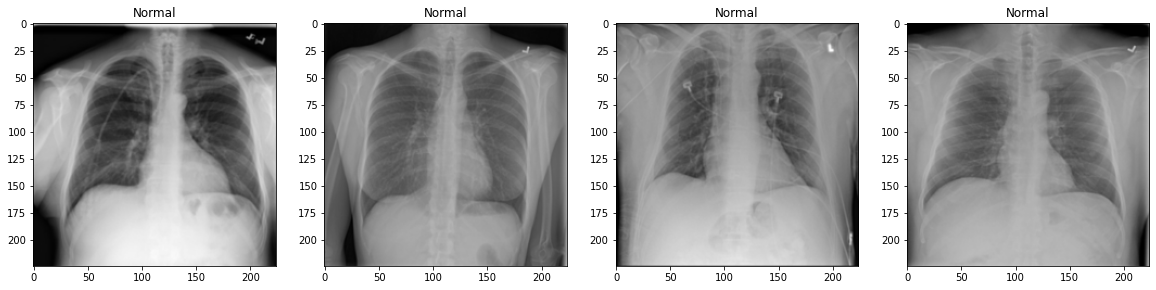

In [4]:
show_img(dataset_path= dataset_path, train= False)

In [4]:
# show_img(dataset_path= dataset_path, train= True) 
model_ft = torchvision.models.alexnet(pretrained=True)
model_ft

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# Train Model

In [5]:
# load pretrained models
model_ft = torchvision.models.alexnet(pretrained=True)

# fine tune fully connected layer
for name, child in model_ft.named_children():
    if name in ['classifier']:
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

# fine tune last convolutional layer
for param in model_ft.features[10:].parameters():
    param.requires_grad = True

# change out_features of last linear layer
model_ft.classifier[6] = nn.Linear(in_features=4096, out_features=4, bias=True)


# Train
torch.manual_seed(RANDOM_SEED)
model_ft.to(DEVICE)
optimizer = torch.optim.Adam(model_ft.parameters(), lr=LEARNING_RATE)  

minibatch_loss_list_ft, train_acc_list_ft, valid_acc_list_ft = train_model(num_epochs = NUM_EPOCHS, model = model_ft, 
                                                                optimizer = optimizer, device = DEVICE, 
                                                                train_loader = train_loader, valid_loader=valid_loader, 
                                                                test_loader = test_loader, logging_interval=50)

Epoch: 001/040 | Batch 0000/0265 | Loss: 1.3167
Epoch: 001/040 | Batch 0050/0265 | Loss: 0.5082
Epoch: 001/040 | Batch 0100/0265 | Loss: 0.5665
Epoch: 001/040 | Batch 0150/0265 | Loss: 0.2775
Epoch: 001/040 | Batch 0200/0265 | Loss: 0.6355
Epoch: 001/040 | Batch 0250/0265 | Loss: 0.2110
Epoch: 001/040 | Train: 89.32% | Validation: 87.81%
Time elapsed: 2.16 min
Epoch: 002/040 | Batch 0000/0265 | Loss: 0.2483
Epoch: 002/040 | Batch 0050/0265 | Loss: 0.3370
Epoch: 002/040 | Batch 0100/0265 | Loss: 0.2812
Epoch: 002/040 | Batch 0150/0265 | Loss: 0.3429
Epoch: 002/040 | Batch 0200/0265 | Loss: 0.4912
Epoch: 002/040 | Batch 0250/0265 | Loss: 0.4677
Epoch: 002/040 | Train: 91.75% | Validation: 89.84%
Time elapsed: 4.30 min
Epoch: 003/040 | Batch 0000/0265 | Loss: 0.2423
Epoch: 003/040 | Batch 0050/0265 | Loss: 0.3780
Epoch: 003/040 | Batch 0100/0265 | Loss: 0.4183
Epoch: 003/040 | Batch 0150/0265 | Loss: 0.2609
Epoch: 003/040 | Batch 0200/0265 | Loss: 0.2782
Epoch: 003/040 | Batch 0250/0265 |

Epoch: 023/040 | Batch 0200/0265 | Loss: 0.1455
Epoch: 023/040 | Batch 0250/0265 | Loss: 0.2430
Epoch: 023/040 | Train: 96.46% | Validation: 93.39%
Time elapsed: 49.15 min
Epoch: 024/040 | Batch 0000/0265 | Loss: 0.1069
Epoch: 024/040 | Batch 0050/0265 | Loss: 0.0858
Epoch: 024/040 | Batch 0100/0265 | Loss: 0.2097
Epoch: 024/040 | Batch 0150/0265 | Loss: 0.0482
Epoch: 024/040 | Batch 0200/0265 | Loss: 0.0597
Epoch: 024/040 | Batch 0250/0265 | Loss: 0.1134
Epoch: 024/040 | Train: 96.39% | Validation: 92.82%
Time elapsed: 51.27 min
Epoch: 025/040 | Batch 0000/0265 | Loss: 0.0394
Epoch: 025/040 | Batch 0050/0265 | Loss: 0.0940
Epoch: 025/040 | Batch 0100/0265 | Loss: 0.1033
Epoch: 025/040 | Batch 0150/0265 | Loss: 0.1454
Epoch: 025/040 | Batch 0200/0265 | Loss: 0.2687
Epoch: 025/040 | Batch 0250/0265 | Loss: 0.1570
Epoch: 025/040 | Train: 97.15% | Validation: 93.39%
Time elapsed: 53.35 min
Epoch: 026/040 | Batch 0000/0265 | Loss: 0.0827
Epoch: 026/040 | Batch 0050/0265 | Loss: 0.1295
Epoc

In [6]:
torch.save(model_ft, os.path.join('.\\models', 'Alexnet_bn64_ep40_old_normalize.pth'))

# Evaluation 

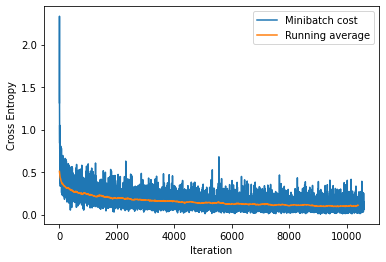

In [7]:
plt.plot(minibatch_loss_list_ft, label='Minibatch cost')
plt.plot(np.convolve(minibatch_loss_list_ft, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

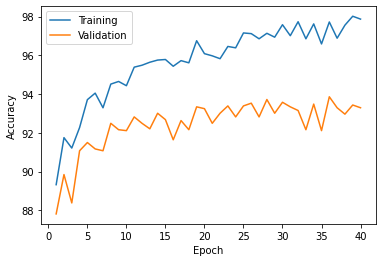

In [8]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list_ft, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list_ft, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


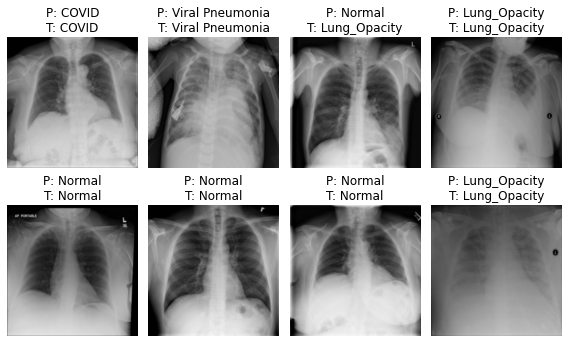

In [10]:
model_ft.cpu()
unnormalizer = UnNormalize((0.4363, 0.4328, 0.3291), (0.2129, 0.2075, 0.2038))
class_dict  = {0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}

show_examples(model=model_ft, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

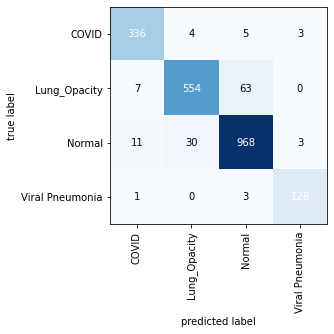

In [10]:
# model_ft = torch.load(os.path.join('.\\models', 'Alexnet_bn64_ep50_1.pth'))
# model_ft.cpu()
class_dict  = {0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}
model_ft.to(DEVICE)

mat = compute_confusion_matrix(model=model_ft, data_loader=test_loader, device=DEVICE)
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

# Precision, Recall, F1


In [2]:
cal_pre_rec(mat)

COVID => Precision: 96.55%, Recall: 94.65%, F1: 95.59%
-----------------
Lung_Opacity => Precision: 88.78%, Recall: 94.22%, F1: 91.42%
-----------------
Normal => Precision: 95.65%, Recall: 93.17%, F1: 94.39%
-----------------
Viral Pneumonia => Precision: 96.97%, Recall: 95.52%, F1: 96.24%
-----------------


# Grad Cam

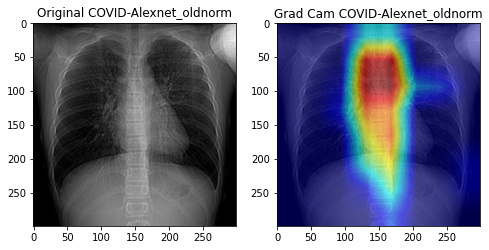

In [13]:
model_ft = torch.load(os.path.join('.\\models', 'Alexnet_bn64_ep40_old_normalize.pth'))
model_ft.to(DEVICE)

for param in model_ft.features.parameters():
    param.requires_grad = True

store_gradcam_image(model_ft, model_ft.features, ['12'], 'Alexnet_oldnorm', 'COVID', 121) 